# Gaussian Covariance Matrix

Following Grieb et al. [arXiv:1509.04293]

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import classylss
import classylss.binding as CLASS
#from scipy.interpolate import InterpolatedUnivariateSpline as Spline
#from scipy.integrate import simps
#from numpy.linalg import inv

In [2]:
cosmo_Planck2015 = CLASS.ClassEngine({'h' : 0.676, 'Omega_b' : 0.022/0.676**2,  'Omega_cdm' : 0.31-0.022/0.676**2, 'n_s' : 0.96, 'A_s' : 2.0e-9, 'non linear' : 'halofit', 'output' : 'tCl,pCl,lCl,mPk', 'P_k_max_h/Mpc' : 10., "z_max_pk" : 100.0})
cosmo_Patchy = CLASS.ClassEngine({'H0' : 67.77, 'Omega_b' : 0.048206,  'Omega_cdm' : 0.307115-0.048206, 'n_s' : 0.9611, 'A_s' : 2.148e-9, 'non linear' : 'halofit', 'output' : 'tCl,pCl,lCl,mPk', 'P_k_max_h/Mpc' : 10., "z_max_pk" : 100.0})
cosmo = cosmo_Patchy
sp = CLASS.Spectra(cosmo)
bg = CLASS.Background(cosmo)

# BOSS DR12-NGC Z3
beff= 2.0
n = 0.0002068
v = 2793308269.42
zeff = 0.61

kmin = 0.0
kmax = 0.6
nkbins = 120

dk = (kmax-kmin)/nkbins
krange = np.linspace(kmin+dk/2, kmax-dk/2, nkbins)

# Use estimated Power Spectrum to compute covariance instead.
#power = np.loadtxt('PowerSpectrum_Patchy-Mocks-DR12CMASSLOWZTOT-N-V6S-Portsmouth-mass_0001.dat', delimiter=' ', comments='# ')
#power = np.loadtxt('PowerSpectrum_Patchy-Mocks-DR12NGC-COMPSAM_V6C_0001.dat', delimiter=' ', comments='# ')
#krange = power[:nkbins,1]
#P0 = power[:nkbins,3]
#P2 = power[:nkbins,4]
#P4 = power[:nkbins,5]

pk_lin = sp.get_pklin(k=krange, z=zeff)
f = bg.scale_independent_growth_rate(zeff)

def getpkmod(b,N):
    
    pk0mod = ( b**2 + 2*b*f/3 + f**2 /5 ) * pk_lin + N
    pk2mod = ( 4*b*f/3 + 4*f**2 /7 ) * pk_lin
    pk4mod = ( 8 * f**2 /35 ) * pk_lin
    
    return pk0mod, pk2mod, pk4mod


P0, P2, P4 = getpkmod(beff,0.)

In [9]:
def sig(k, l1, l2):    
    ''' Computes the sigma^2 funtions for multipoles l1 and l2. (eq.A5) '''
    
    if (l1 + l2 == 0):
        s2 = 2. / v * ( ( P0 + 1. / n ) * ( P0 + 1. / n ) + 1. / 5. * P2 * P2 + 1. / 9. * P4 * P4 )
    elif (l1 + l2 == 2):
        s2 = 2. / v * ( 2. * ( P0 + 1. / n ) * P2 + 2. / 7. * P2 * P2 + 4. / 7. * P2 * P4 + 100. / 693. * P4 * P4 )
    elif (l1 + l2 == 4):
        s2 = 2. / v * ( 5. * ( P0 + 1. / n ) * ( P0 + 1. / n ) + 20. / 7. * ( P0 + 1. / n ) * ( P2 + P4 ) \
            + 15. / 7 * P2 * P2 + 120. / 77. * P2 * P4 + 8945. / 9009. * P4 * P4)
    else:
        print('Error')
                      
    s2 *= k**2
    
    return s2


def covll(k, l1, l2):
    ''' 
    Computes the covariance matrix element C(k) for the multipoles l1 and l2 . (eq.16)
    
    '''
    
    Vk = 4. * np.pi * k * k * dk + np.pi * dk**3. / 3.
    
    covariance = 2. * ( 2. * np.pi )**4. * sig(krange,l1,l2) * dk / Vk**2. 
        
    return covariance


def cov():
    ''' Computes the full covariance matrix C '''
    
    cov00 = np.zeros((nkbins,nkbins))
    cov02 = cov00
    cov20 = cov00
    cov22 = cov00
    
    cov00 = np.diag(covll(krange,0,0))
    cov02 = np.diag(covll(krange,0,2))
    cov20 = cov02
    cov22 = np.diag(covll(krange,2,2))
        
    cov1 = np.concatenate((cov00, cov02), axis=1)
    cov2 = np.concatenate((cov20, cov22), axis=1)
    covfull = np.concatenate((cov1, cov2), axis=0) 
    
    return covfull

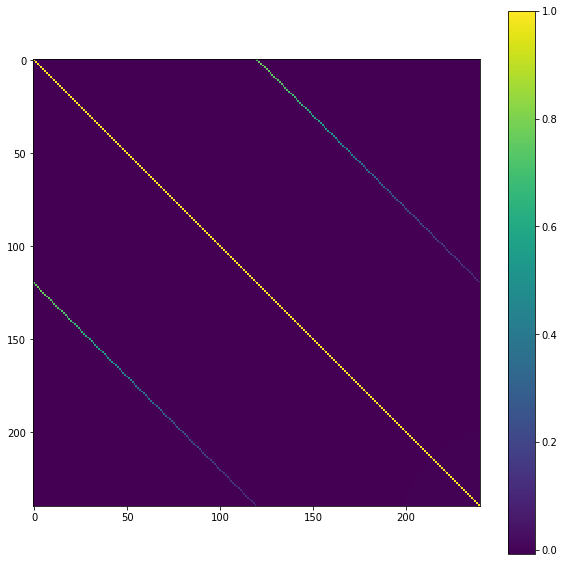

In [10]:
#Monopole & Quadrupole
covariance = cov()
np.shape(covariance)
covariancers= covariance.reshape(240*240)
np.savetxt('covariance02.dat', covariancers, delimiter=' ', newline='\n', header='P0 and P2 covariance matrix 240 x 240', comments='# ')
plt.figure(figsize=(10,10))
plt.imshow(np.corrcoef(covariance))
plt.colorbar()

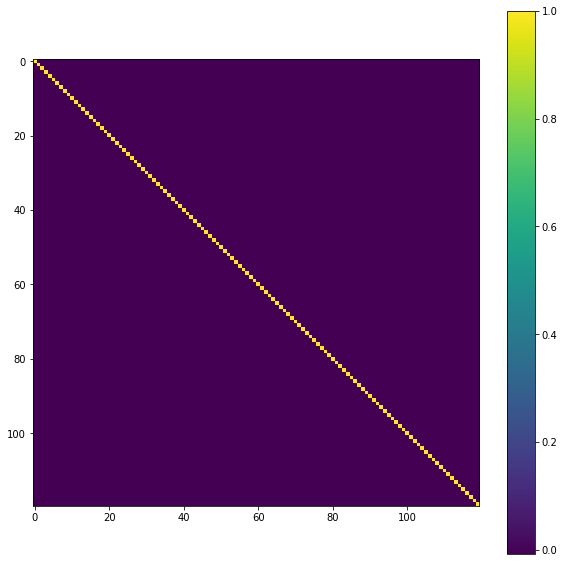

In [11]:
#Monopole 
cov_mono = cov()[:120,:120]
covariancers= cov_mono.reshape(120*120)
np.savetxt('covariance0.dat', covariancers, delimiter=' ', newline='\n', header='P0 covariance matrix 120 x 120', comments='# ')
plt.figure(figsize=(10,10))
plt.imshow(np.corrcoef(cov_mono))
plt.colorbar()
plt.show()